# Planet: Understanding the Amazon deforestation from Space challenge

from https://github.com/EKami/planet-amazon-deforestation

Special thanks to the kernel contributors of this challenge (especially @anokas and @Kaggoo) who helped me find a starting point for this notebook.

The whole code including the `data_helper.py` and `keras_helper.py` files are available on github [here](https://github.com/EKami/planet-amazon-deforestation) and the notebook can be found on the same github [here](https://github.com/EKami/planet-amazon-deforestation/blob/master/notebooks/amazon_forest_notebook.ipynb)

**If you found this notebook useful some upvotes would be greatly appreciated! :) **

Start by adding the helper files to the python path

## Import required modules

In [1]:
import os
import gc
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau, History
from tensorflow.keras.applications import ResNet50, VGG16
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Input, Dense, Flatten, AveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

config = tf.ConfigProto( device_count = {'GPU': 1 , 'CPU': 16} ) 
config.gpu_options.allow_growth = True
sess = tf.Session(config=config) 
tf.keras.backend.set_session(sess)

Print tensorflow version for reuse (the Keras module is used directly from the tensorflow framework)

In [2]:
tf.__version__

'1.15.0'

## Images
Visualize some chip images to know what we are dealing with.
Lets vizualise 1 chip for the 17 images to get a sense of their differences.

# Image resize & validation split
Define the dimensions of the image data trained by the network. Recommended resized images could be 32x32, 64x64, or 128x128 to speedup the training. 

You could also use `None` to use full sized images.

Be careful, the higher the `validation_split_size` the more RAM you will consume.

In [3]:
dataset = '../data/satellite/amazon/'
model_path = 'weights/amazon_weights128.best.hdf5'
tag = 'agri'

# dataset = '../data/satellite/oilpalm/'
# model_path = 'weights/oilpalm_weights128.best.hdf5'
# tag = 'palm'

In [4]:
img_resize = (128, 128) # The resize size of each image ex: (64, 64) or None to use the default image size

batch_size = 64
steps = int(2112 / batch_size)

In [5]:
datagen = ImageDataGenerator(
            rescale=1./255,
            shear_range=0.2,
            horizontal_flip=True,
            vertical_flip=True) 

In [6]:
train_generator = datagen.flow_from_directory(
        dataset + 'train',
        target_size=(128, 128),
        batch_size=128,
        class_mode='categorical')

Found 1055 images belonging to 2 classes.


In [7]:
print(len(train_generator))

9


In [8]:
datagen = ImageDataGenerator(
            rescale=1./255) 

In [9]:
val_generator = datagen.flow_from_directory(
        dataset + 'test',
        target_size=(128, 128),
        batch_size=128,
        class_mode='categorical')

Found 1056 images belonging to 2 classes.


In [10]:
print(len(val_generator))

9


# Data preprocessing
Due to the hudge amount of memory the preprocessed images can take, we will create a dedicated `AmazonPreprocessor` class which job is to preprocess the data right in time at specific steps (training/inference) so that our RAM don't get completely filled by the preprocessed images. 

The only exception to this being the validation dataset as we need to use it as-is for f2 score calculation as well as when we calculate the validation accuracy of each batch.

# Funetuning

Here we define the model for finetuning

In [11]:
# model = vgg16.create_model(img_dim=(128, 128, 3))


baseModel = VGG16(weights="imagenet", include_top=False, input_tensor=Input(shape=(128, 128, 3)))

# construct the head of the model that will be placed on top of the
# the base model
headModel = baseModel.output
# headModel = AveragePooling2D(pool_size=(4, 4))(headModel)
headModel = Flatten(name="flatten")(headModel)
# headModel = Dense(128, activation="relu")(headModel)
# headModel = Dropout(0.5)(headModel)
headModel = Dense(2, activation="softmax")(headModel)


model = Model(inputs=baseModel.input, outputs=headModel)

model.summary()

# model.summary()

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 128, 128, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 128, 128, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 128, 128, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 64, 64, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 64, 64, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 64, 64, 128)       147584    
______________________________________________

## Fine-tune conv layers
We will now finetune all layers in the VGG16 model. 

In [12]:
history = History()
callbacks = [history, 
             EarlyStopping(monitor='val_loss', patience=3, verbose=1, min_delta=1e-4),
             ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=1, cooldown=0, min_lr=1e-7, verbose=1),
             ModelCheckpoint(filepath=model_path, verbose=1, save_best_only=True, 
                             save_weights_only=True, mode='auto')]

model.compile(optimizer=Adam(lr=1e-4), loss='binary_crossentropy', metrics = ['accuracy'])
history = model.fit_generator(train_generator, 
                    steps, 
                    epochs=25, 
                    verbose=1, 
                    validation_data=val_generator,
                    validation_steps=5,
                    callbacks=callbacks)

Epoch 1/25
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
 5/33 [===>..........................] - ETA: 5s - loss: 0.4232 - acc: 0.8141
Epoch 00001: val_loss improved from inf to 0.42316, saving model to weights/amazon_weights128.best.hdf5
33/33 [==============================] - 22s 669ms/step - loss: 0.5619 - acc: 0.6926 - val_loss: 0.4232 - val_acc: 0.8141
Epoch 2/25
 5/33 [===>..........................] - ETA: 5s - loss: 0.3865 - acc: 0.8141
Epoch 00002: val_loss improved from 0.42316 to 0.38651, saving model to weights/amazon_weights128.best.hdf5
33/33 [==============================] - 13s 393ms/step - loss: 0.3909 - acc: 0.8342 - val_loss: 0.3865 - val_acc: 0.8141
Epoch 3/25
 5/33 [===>..........................] - ETA: 5s - loss: 0.3474 - acc: 0.8547
Epoch 00003: val_loss improved from 0.38651 to 0.34743, saving model to weights/amazon_weights128.best.hdf5
33/33 [==============================] - 13s 400ms/step - loss: 0.3306 - ac

## Visualize Loss Curve

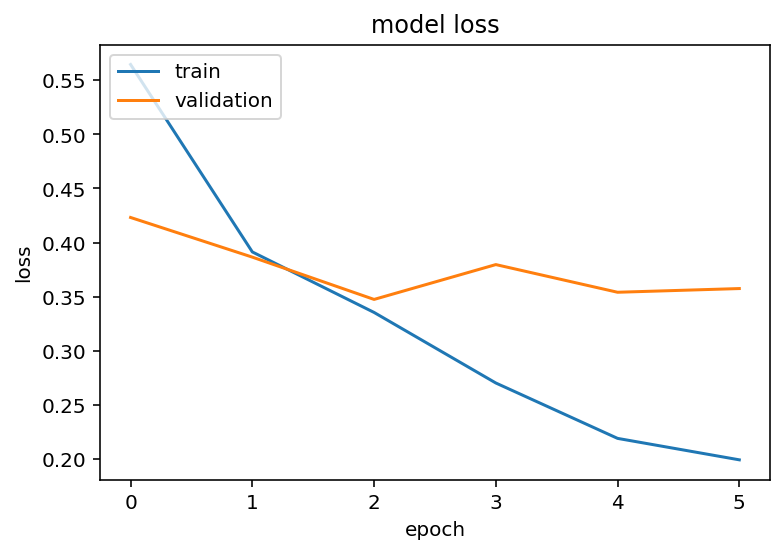

In [13]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

## Load Best Weights

In [14]:
model.load_weights(model_path)
print("Weights loaded")

Weights loaded


## Make predictions

In [15]:
test_datagen = ImageDataGenerator(rescale=1/255.)

test_generator = test_datagen.flow_from_directory(
                              dataset + 'test',
                              classes=None,
                              class_mode=None,
                              shuffle=False,
                              target_size=(128, 128))

Found 1056 images belonging to 2 classes.


In [16]:
filenames = test_generator.filenames
nb_samples = len(filenames)

In [17]:
y_test = np.array([int(f.split('/')[-2] != next(iter(test_generator.class_indices))) for f in filenames])

In [18]:
preds = model.predict_generator(test_generator)

In [19]:
predIdxs = preds.argmax(axis=1)

In [20]:
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
print("-------------------------------")
print(classification_report(y_test, predIdxs, target_names=['no_'+tag, tag], digits=3))
print(confusion_matrix(y_test, predIdxs))

-------------------------------
              precision    recall  f1-score   support

     no_agri      0.847     0.830     0.838       493
        agri      0.853     0.869     0.861       563

    accuracy                          0.850      1056
   macro avg      0.850     0.849     0.850      1056
weighted avg      0.850     0.850     0.850      1056

[[409  84]
 [ 74 489]]


Before mapping our predictions to their appropriate labels we need to figure out what threshold to take for each class

Now lets map our predictions to their tags by using the thresholds

Finally lets assemble and visualize our predictions for the test dataset

#### That's it, we're done!

Amazon

-------------------------------
              precision    recall  f1-score   support

     no_agri      0.875     0.853     0.864       985
        agri      0.874     0.894     0.884      1127

    accuracy                          0.875      2112
   macro avg      0.875     0.873     0.874      2112
weighted avg      0.875     0.875     0.874      2112

[[ 840  145]
 [ 120 1007]]

Oil Palm

-------------------------------
              precision    recall  f1-score   support

     no_palm      0.693     0.790     0.738       100
        palm      0.734     0.624     0.674        93

    accuracy                          0.710       193
   macro avg      0.714     0.707     0.706       193
weighted avg      0.713     0.710     0.708       193

[[79 21]
 [35 58]]

-------------------------------
              precision    recall  f1-score   support

     no_palm      0.714     0.900     0.796       100
        palm      0.851     0.613     0.713        93

    accuracy                          0.762       193
   macro avg      0.783     0.756     0.754       193
weighted avg      0.780     0.762     0.756       193

[[90 10]
 [36 57]]